In [1]:
%pip install open_clip_torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import cv2
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

import open_clip
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

C:\Users\CYTech Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# create the dataset
with open('descriptions.json') as jsonfile:
    descriptions = json.load(jsonfile)

dataset = []
for desc in descriptions:
    image = cv2.imread(f"images/{desc['code']}.jpg")
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    patch_height = image.shape[0] // 2
    top_img = cv2.resize(image[:patch_height], (1024, 1024))
    bottom_img = cv2.resize(image[patch_height:], (1024, 1024))
    description = desc['description']
    dataset.append((top_img, description))
    dataset.append((bottom_img, description))

print(len(dataset), "images loaded")

186 images loaded


In [4]:
# create batches so that all descriptions in a given batch are different
batches = []
batch = []
current_desc = None
unused = dataset.copy()
max_iter = 1000
iter = 0
while len(unused) > 0 and iter < max_iter:
    # pick a random index in the unused list
    index = random.randint(0, len(unused)-1)
    img, desc = unused[index]
    if desc != current_desc:
        # if the description is different from the previous one, add the image to the batch
        batch.append(unused.pop(index))
        current_desc = desc
    if len(batch) == 2:
        # if the batch is full, add it to the list of batches
        batches.append(batch)
        batch = []
        current_desc = None
        if iter%5==0: print(iter, len(batches), len(unused))
    iter += 1
print(iter, len(batches), len(unused))
print(f"{len(batches)} batches of 2 images created, {len(unused)} images left unused")

30 7 172
35 9 168
180 21 144
195 24 138
1000 34 117
34 batches of 2 images created, 117 images left unused


# Choix, entraînement ou fine-tuning et comparaison de deux modèles

In [5]:
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32', 'datacomp_xl_s13b_b90k'),
 ('ViT-B-32', 'datacomp_m_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_clip_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_laion_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_image_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_text_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_basic_s128m_b4k'),
 ('ViT-B-32', 'commonpool_m_s128m_b4k'),
 ('ViT-B-32', 'datacomp_s_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_clip_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_laion_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_image_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_text_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_basic_s13m_b4k'),
 ('ViT-B-32', 'commonpool_s_s13m_b4k'),
 ('ViT-

# Modèle 1 : CoCa

- https://github.com/mlfoundations/open_clip
- [CoCa Colab](https://colab.research.google.com/github/mlfoundations/open_clip/blob/master/docs/Interacting_with_open_coca.ipynb)

In [6]:
model, _, preprocess  = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

tokenizer = open_clip.get_tokenizer("coca_ViT-L-14")

`model` est un objet `CoCa`


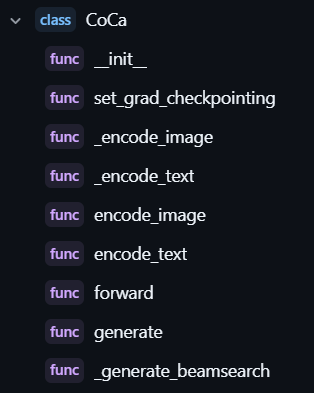

A plant with thorns. Its leaves are not acuminate.


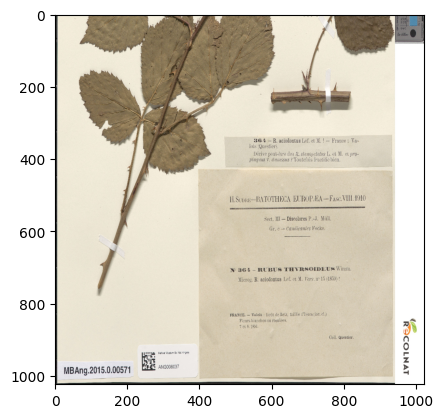

In [7]:
# take a random image
random_row = random.choice(dataset)
print(random_row[1])
plt.imshow(random_row[0])
plt.show()

In [8]:
# What can the model say about this image?

img = preprocess(Image.fromarray(random_row[0])).unsqueeze(0)

with torch.no_grad():
  generated = model.generate(img)

print(open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", ""))

a close up of a plant on a table . 


In [9]:
images, descriptions = zip(*batches[0])
print("Descriptions:", descriptions)

images = torch.stack([preprocess(Image.fromarray(img)) for img in images])
descriptions = tokenizer(descriptions)
print(f"Images shape: {images.shape}, Descriptions shape: {descriptions.shape}")

out_dict = model.forward(images, descriptions)

print("\nOutput:")
for key, value in out_dict.items():
    print(key, value.shape)

Descriptions: ('A plant with thorns. Its leaves are not acuminate.', 'A plant with thorns. Its leaves are acuminate.')
Images shape: torch.Size([2, 3, 224, 224]), Descriptions shape: torch.Size([2, 76])

Output:
image_features torch.Size([2, 768])
text_features torch.Size([2, 768])
logits torch.Size([2, 75, 49408])
logit_scale torch.Size([])
labels torch.Size([2, 75])


[inspiration](https://medium.com/aimonks/a-guide-to-fine-tuning-clip-models-with-custom-data-6c7c0d1416fb) pour cette cellule

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
# create a CoCaLoss object
loss = open_clip.CoCaLoss(
    caption_loss_weight=1.0,
    clip_loss_weight=1.0,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for batch in tqdm(batches):
    images, texts = zip(*batch)
    images = torch.stack([preprocess(Image.fromarray(img)) for img in images])
    texts = tokenizer(texts)
    images = images.to(device)
    texts = texts.to(device)

    optimizer.zero_grad()

    # forward pass
    out_dict = model.forward(images, texts)

    # compute loss
    # unwrap out_dict to give it to the loss function
    clip_loss, caption_loss = loss.forward(
        image_features=out_dict['image_features'],
        text_features=out_dict['text_features'],
        logits=out_dict['logits'],
        labels=out_dict['labels'],
        logit_scale=out_dict['logit_scale']
    )
    total_loss = clip_loss + caption_loss

    # backward pass
    total_loss.backward()

    optimizer.step()

100%|██████████| 34/34 [07:39<00:00, 13.51s/it]
